In [ ]:
pip install pytesseract pyefd skan easyocr

In [ ]:
import cv2
import numpy as np
import os
from imutils.contours import sort_contours
from collections import defaultdict
import pytesseract
import re
import pywt
import pyefd
from skimage.feature import hog
from skimage.measure import block_reduce
from skimage.morphology import skeletonize
from skan import csr
import networkx as nx
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
import easyocr

In [ ]:
class PageSegmenter:
    """
    Class to segment a full-page image into individual word fragments
    and extract text using EasyOCR.
    """

    def __init__(self, output_dir: str = 'word_fragments'):
        self.output_dir = os.path.join(output_dir, 'fragments')
        os.makedirs(self.output_dir, exist_ok=True)
        # Initialize EasyOCR Reader
        self.reader = easyocr.Reader(['en'], gpu=False)


    def _clean_text(self, text: str) -> str:
        """
        Cleans the raw OCR output.
        Removed digits from cleaning as they can be part of words or important identifiers.
        """
        # Remove non-alphabetic characters and newlines, keep digits
        return re.sub(r'[^a-zA-Z0-9]', '', text).strip().lower()


    def segment_page(self, image_path: str, page_id: str) -> dict:
        """
        Main method to run the full segmentation and OCR pipeline using EasyOCR.
        Saves fragments and returns a dictionary with page ID and a list of
        word fragment data (text, path, bbox).
        """
        print(f"Processing {page_id} from {image_path} using EasyOCR...")
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")

        try:
            # Use EasyOCR to read text and get bounding boxes
            results = self.reader.readtext(image, detail=1)
        except Exception as e:
            print(f"❌ EasyOCR failed on {image_path}: {e}")
            return {"page_id": page_id, "fragments": []}


        page_fragments_data = []
        word_count = 0

        # EasyOCR results are generally ordered, so we can use a simple counter for line/word
        for i, (bbox, text, conf) in enumerate(results):
            cleaned_text = self._clean_text(text)

            if not cleaned_text:
                continue

            # Extract bounding box coordinates
            bbox = np.array(bbox).astype(int)
            x_min, y_min = bbox[:,0].min(), bbox[:,1].min()
            x_max, y_max = bbox[:,0].max(), bbox[:,1].max()

            # Clamp coordinates to image dimensions
            y_min, y_max = max(0, y_min), min(image.shape[0], y_max)
            x_min, x_max = max(0, x_min), min(image.shape[1], x_max)

            if y_max <= y_min or x_max <= x_min:
                continue

            # Crop the word fragment
            crop = image[y_min:y_max, x_min:x_max]
            if crop.size == 0:
                continue

            # Convert cropped fragment to grayscale before saving
            crop_gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)

            # Create filename and path
            # Using a single counter 'i' as EasyOCR provides an ordered list
            fragment_name = f"{page_id}_word_{i:04d}.png"
            fragment_path = os.path.join(self.output_dir, fragment_name)

            # Save the cropped fragment
            cv2.imwrite(fragment_path, crop_gray)

            page_fragments_data.append({
                "text": cleaned_text,
                "conf": float(conf), # Confidence score from EasyOCR
                "bbox": [int(x_min), int(y_min), int(x_max), int(y_max)],
                "fragment_path": os.path.abspath(fragment_path)
            })
            word_count += 1

        print(f"Saved {word_count} word fragments for {page_id}.")
        # Return the structured data which will serve as the new lookup map
        return {"page_id": page_id, "fragments": page_fragments_data}

In [ ]:
# The OCRMapper class is no longer needed for building the lookup map
# as PageSegmenter now performs this function.
# However, we keep it for the find_common_candidates method.
class OCRMapper:
    """
    Finds biometrically-rich common words between pages using the data
    provided by the refactored PageSegmenter.
    """

    def find_common_candidates(self,
                               page1_fragments_data: list[dict],
                               page2_fragments_data: list[dict],
                               min_word_length: int = 3) -> set[str]:
        """
        Finds common words between the fragment data from two pages
        and applies a biometric quality filter.
        """
        # Create sets of cleaned text from each page's fragments
        keys1 = {f['text'] for f in page1_fragments_data if 'text' in f}
        keys2 = {f['text'] for f in page2_fragments_data if 'text' in f}


        # Find common keys using set intersection
        common_keys = keys1 & keys2

        # Apply biometric quality filter: longer words are more stable
        # and representative of a writer's habits.
        filtered_candidates = {
            word for word in common_keys
            if len(word) >= min_word_length
        }

        print(f"Found {len(filtered_candidates)} biometrically-rich candidates.")
        return filtered_candidates

In [ ]:
class HandcraftedFeatureExtractor:
    """
    Extracts a comprehensive, fixed-length feature vector from a
    single binary word fragment.
    """

    def __init__(self, fixed_size=(64, 128), zone_grid=(5, 5)):
        self.fixed_size = fixed_size
        self.zone_grid = zone_grid

    def _resize(self, img: np.ndarray) -> np.ndarray:
        """Resizes and normalizes image."""
        # Ensure image is binary (0 or 255)
        _, resized = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        # Ensure self.fixed_size is passed as a tuple of integers
        resized = cv2.resize(resized, (int(self.fixed_size[1]), int(self.fixed_size[0])))
        return resized

    def _get_structural_features(self, binary_img: np.ndarray) -> np.ndarray:
        """Uses skan and networkx for skeleton graph analysis."""
        skeleton = skeletonize(binary_img // 255).astype(np.uint8)
        if np.sum(skeleton) == 0:
            return np.zeros(4)

        try:
            # skan.csr.summarise returns a DataFrame of all branches
            branch_data = csr.summarise(skeleton)
            branch_count = len(branch_data)
            endpoint_branch_count = branch_data['branch-type'].isin([1, 13]).sum() # Corrected .isin()
            mean_branch_length = branch_data['branch-distance'].mean()

            # Find loops with networkx
            graph = csr.skeleton_to_nx(skeleton)
            loop_count = len(list(nx.cycle_basis(graph))) # Corrected find_cycle to cycle_basis
        except Exception:
            # Handle cases with no valid skeleton graph
            return np.zeros(4)

        features = [branch_count, endpoint_branch_count, mean_branch_length, loop_count]
        return np.nan_to_num(features)


    def _get_geometric_features(self, binary_img: np.ndarray) -> np.ndarray:
        """Extracts slant, aspect ratio, and baseline features."""
        contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            return np.zeros(4)

        main_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(main_contour)

        # 1. Aspect Ratio
        aspect_ratio = w / float(h) if h > 0 else 0

        # 2. Slant Angle via minAreaRect
        coords = np.column_stack(np.where(binary_img > 0))
        if len(coords) < 5: # minAreaRect needs at least 5 points
            return np.array([aspect_ratio, 0, 0, 0])

        angle = cv2.minAreaRect(coords.astype(np.float32))[-1]
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        # 3. Baseline Deviation
        hpp = np.sum(binary_img, axis=1)
        baseline_y = np.argmax(hpp) if np.sum(hpp) > 0 else 0

        M = cv2.moments(main_contour)
        cy = int(M['m01'] / M['m00']) if M['m00'] > 0 else 0
        baseline_centroid_dist = float(cy - baseline_y)

        # 4. Descender Variability
        contour_points = main_contour.squeeze()
        if contour_points.ndim == 1: # Handle case where squeeze results in 1D array
             contour_points = contour_points.reshape(-1, 2)
        descender_points = contour_points[contour_points[:, 1] > baseline_y]
        descender_stddev = np.std(descender_points[:, 1]) if len(descender_points) > 0 else 0

        features = [aspect_ratio, angle, baseline_centroid_dist, descender_stddev]
        return np.nan_to_num(features)

    def _get_statistical_features(self, resized_img: np.ndarray) -> np.ndarray:
        """Extracts HOG and Zonal Density features."""

        # 1. HOG (Histogram of Oriented Gradients) [50]
        try:
            hog_features = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                               cells_per_block=(2, 2), visualize=False)
        except ValueError: # Handle cases where HOG computation fails (e.g., very small image)
            hog_features = np.zeros(324) # Default HOG feature length for 64x128 with these params


        # 2. Pixel Density Zoning [54, 55]
        block_h = self.fixed_size[0] // self.zone_grid[0]
        block_w = self.fixed_size[1] // self.zone_grid[1]

        # Handle potential zero division or small image size
        if block_h == 0 or block_w == 0:
             zoning_features = np.zeros(self.zone_grid[0] * self.zone_grid[1])
        else:
            # np.mean on binary image is pixel density
            zoning_features = block_reduce(
                resized_img,
                block_size=(block_h, block_w),
                func=np.mean
            ).flatten()

        return np.concatenate([hog_features, zoning_features])

    def _get_transform_features(self, resized_img: np.ndarray) -> np.ndarray:
        """Extracts Fourier Descriptors and Wavelet statistics."""

        # 1. Elliptic Fourier Descriptors (EFD)
        contours, _ = cv2.findContours(resized_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if not contours:
            efd_features = np.zeros(20) # 10th order EFD has 20 features
        else:
            main_contour = max(contours, key=cv2.contourArea).squeeze()
            if len(main_contour.shape) == 1: # Handle case where squeeze results in 1D array
                 main_contour = main_contour.reshape(-1, 2)

            if len(main_contour) < 4: # EFD requires at least 4 points
                efd_features = np.zeros(20)
            else:
                coeffs = pyefd.elliptic_fourier_descriptors(main_contour, order=10, normalize=True)
                efd_features = coeffs.flatten()[3:] # Discard redundant
                if len(efd_features)!= 20: # Fallback
                     efd_features = np.zeros(20)


        # 2. Wavelet Transform (DWT) Statistics [61, 64]
        try:
            coeffs2 = pywt.dwt2(resized_img.astype(np.float64), 'bior1.3') # Ensure float64
            LL, (LH, HL, HH) = coeffs2
            wavelet_stats = np.array([
                np.mean(LH), np.std(LH),
                np.mean(HL), np.std(HL),
                np.mean(HH), np.std(HH)
            ])
        except ValueError: # Handle cases where DWT fails (e.g., small image)
             wavelet_stats = np.zeros(6)


        return np.concatenate([efd_features, wavelet_stats])

    def extract_features(self, img_path: str) -> np.ndarray:
        """
        Main method to extract the full, concatenated feature vector.
        """
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise FileNotFoundError(f"Image not found at {img_path}")

        resized_img = self._resize(img)

        f_struct = self._get_structural_features(resized_img)
        f_geom = self._get_geometric_features(resized_img)
        f_stat = self._get_statistical_features(resized_img)
        f_trans = self._get_transform_features(resized_img)

        # Concatenate all features into a single 1D vector
        final_vector = np.concatenate([f_struct, f_geom, f_stat, f_trans])

        return final_vector

In [ ]:
from scipy.spatial.distance import euclidean

class HandcraftedVerifier:
    """
    Compares common words using the handcrafted feature pipeline
    and aggregates a final, weighted verification score.
    Modified to use StandardScaler, consistency weighting, and Euclidean Distance.
    """
    def __init__(self, threshold: float = 10.0): # Adjust threshold for distance
        self.extractor = HandcraftedFeatureExtractor()
        self.threshold = threshold
        self.scaler = StandardScaler() # Initialize StandardScaler

    def _get_feature_map(self, fragments_data: list[dict],
                           common_words: set[str]) -> tuple[defaultdict[str, list[np.ndarray]], defaultdict[str, np.ndarray]]:
        """
        Pre-computes feature vectors for all common word fragments and calculates consistency metrics.
        Returns a tuple: (feature_map, consistency_map).
        """
        print("Computing feature vectors and consistency for common words...")
        feature_map = defaultdict(list)
        all_features = [] # Collect all feature vectors for scaling
        word_features_grouped = defaultdict(list) # Group features by word for consistency calculation

        for fragment in fragments_data:
            word = fragment.get('text')
            fragment_path = fragment.get('fragment_path')
            if word in common_words and fragment_path:
                try:
                    features = self.extractor.extract_features(fragment_path)
                    feature_map[word].append(features)
                    all_features.append(features)
                    word_features_grouped[word].append(features)
                except Exception as e:
                    print(f"Warning: Feature extraction failed for {fragment_path}: {e}")

        # Fit the scaler on all collected features
        if all_features:
            # Handle potential errors if feature extraction yielded empty arrays
            all_features = [f for f in all_features if f is not None and f.size > 0]
            if all_features:
                self.scaler.fit(all_features)

        # Calculate consistency metric for each word (e.g., inverse of variance)
        consistency_map = {}
        for word, features_list in word_features_grouped.items():
             if len(features_list) > 1:
                 # Calculate variance across features for each word
                 feature_variance = np.var(features_list, axis=0)
                 # Use a small epsilon to avoid division by zero for features with zero variance
                 consistency = 1.0 / (feature_variance.mean() + 1e-6)
                 consistency_map[word] = consistency
             elif len(features_list) == 1:
                 # Assign a default consistency value for words with only one fragment
                 consistency_map[word] = 1.0
             else:
                 consistency_map[word] = 0.0 # Should not happen if features_list is not empty

        return feature_map, consistency_map


    def verify_writers(self,
                       page1_fragments_data: list[dict],
                       page2_fragments_data: list[dict],
                       common_words: set[str]) -> dict:

        feature_map1, consistency_map1 = self._get_feature_map(page1_fragments_data, common_words)
        feature_map2, consistency_map2 = self._get_feature_map(page2_fragments_data, common_words)

        all_distances = []
        all_weights = []

        # Ensure scaler is fitted before proceeding
        if not hasattr(self.scaler, 'mean_'):
             return {"decision": "Inconclusive", "score": 0.0, "reason": "Scaler not fitted. No features extracted."}


        for word in common_words:
            vectors1 = feature_map1.get(word, [])
            vectors2 = feature_map2.get(word, [])

            if not vectors1 or not vectors2:
                continue

            # Get consistency scores for the word from both pages
            consistency1 = consistency_map1.get(word, 1.0) # Default to 1.0 if not enough fragments for variance
            consistency2 = consistency_map2.get(word, 1.0)


            # Compare all-against-all for this word
            for v1 in vectors1:
                for v2 in vectors2:
                    # Scale the feature vectors
                    v1_scaled = self.scaler.transform(v1.reshape(1, -1)).ravel()
                    v2_scaled = self.scaler.transform(v2.reshape(1, -1)).ravel()

                    # Compute Euclidean Distance on scaled features
                    dist = euclidean(v1_scaled, v2_scaled)


                    if not np.isnan(dist):
                        all_distances.append(dist)
                        # New weighting: combination of word length and average consistency
                        weight = len(word) * ((consistency1 + consistency2) / 2.0)
                        all_weights.append(weight)

        if not all_distances or np.sum(all_weights) == 0: # Handle case where all weights are zero
            return {"decision": "Inconclusive", "score": 0.0, "reason": "No valid word pairs to compare or zero weights."}

        # Compute final score as a weighted average of distances
        final_distance = np.average(all_distances, weights=all_weights)

        # Make thresholded decision (smaller distance means Same Writer)
        decision = "Same Writer" if final_distance <= self.threshold else "Different Writers"

        return {
            "decision": decision,
            "score": float(final_distance), # Reporting distance now
            "common_words_compared": len(common_words),
            "total_comparisons": len(all_distances)
        }


In [ ]:
class SiameseVerifier:
    """
    Implements the Deep Learning pipeline (Method B.2).
    Uses a trained CNN 'base_model' to extract powerful feature embeddings
    from word fragments.
    """

    def __init__(self, base_model_path: str = None, threshold: float = 0.8):
        # Setting base_model_path to None allows using the mock model if no path is provided
        self.base_model = self._load_base_model(base_model_path)
        self.threshold = threshold
        # Get embedding size from the model's output - handle mock model case
        self.embedding_dim = self.base_model.output_shape[-1] if base_model_path else 128


    def _load_base_model(self, model_path: str):
        """Loads the pre-trained 'sister' (embedding) network."""
        if model_path and os.path.exists(model_path):
             print(f"Loading base embedding model from {model_path}...")
             try:
                 model = tf.keras.models.load_model(model_path)
                 print("Model loaded successfully.")
                 return model
             except Exception as e:
                 print(f"Error loading model from {model_path}: {e}")
                 print("Falling back to mock model.")
                 return self._create_mock_model()
        else:
            if model_path:
                print(f"Warning: Model path {model_path} not found. Using mock model.")
            else:
                 print("No model path provided. Using mock model.")
            return self._create_mock_model()


    def _create_mock_model(self):
        """Mock model for demonstration without a pre-trained file."""
        print("Creating mock model...")
        img_input = Input(shape=(64, 128, 1))
        # Simple hash of image to create a consistent random vector
        def hash_vector(img):
            # Ensure img is cast to a numeric type before flatten
            img_flat = K.flatten(tf.cast(img, tf.float32))
            hash_val = K.sum(img_flat)
            # Create a 'random' but deterministic vector
            return K.sin(tf.cast(hash_val, 'float32') + tf.range(0, 128, dtype='float32'))

        embedding = Lambda(hash_vector)(img_input)
        model = Model(img_input, embedding)
        print("Mock model created.")
        return model


    def _preprocess_fragment(self, img_path: str) -> np.ndarray:
        """Prepares a fragment for the CNN."""
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
             print(f"Warning: Could not read image at {img_path}")
             return None
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        # Resize to (width, height) for consistency with Keras input shape
        resized = cv2.resize(binary, (self.base_model.input_shape[2], self.base_model.input_shape[1]))
        normalized = resized / 255.0
        # Add batch and channel dimensions: (1, height, width, 1)
        return np.expand_dims(np.expand_dims(normalized, axis=0), axis=-1)


    def _get_embedding(self, img_path: str) -> np.ndarray:
        """Runs Step 4 (DL): Extract deep feature vector."""
        processed_img = self._preprocess_fragment(img_path)
        if processed_img is None:
            return None
        # base_model.predict returns a (1, embedding_dim) vector
        embedding = self.base_model.predict(processed_img, verbose=0) # Set verbose to 0 to suppress progress bar
        return embedding.ravel()


    def verify_writers(self,
                       page1_fragments_data: list[dict],
                       page2_fragments_data: list[dict],
                       common_words: set[str]) -> dict:

        all_scores = []
        all_weights = []

        print("Comparing with Deep Learning (Siamese) pipeline...")

        # Create temporary lookup maps from the fragment data for efficient access
        lookup1 = defaultdict(list)
        for fragment in page1_fragments_data:
             if fragment['text'] in common_words:
                 lookup1[fragment['text']].append(fragment['fragment_path'])

        lookup2 = defaultdict(list)
        for fragment in page2_fragments_data:
             if fragment['text'] in common_words:
                 lookup2[fragment['text']].append(fragment['fragment_path'])


        for word in common_words:
            paths1 = lookup1.get(word, []) # Ensure default is empty list
            paths2 = lookup2.get(word, []) # Ensure default is empty list

            if not paths1 or not paths2:
                continue

            # Pre-compute embeddings to be efficient
            vectors1 = [self._get_embedding(p) for p in paths1]
            vectors2 = [self._get_embedding(p) for p in paths2]

            # Filter out any None embeddings if image reading failed
            vectors1 = [v for v in vectors1 if v is not None]
            vectors2 = [v for v in vectors2 if v is not None]

            if not vectors1 or not vectors2:
                 print(f"Warning: No valid embeddings for word '{word}'. Skipping.")
                 continue

            # Compare all-against-all for this word
            for v1 in vectors1:
                for v2 in vectors2:
                    # Step 5 (DL): Compare embeddings with Cosine Similarity
                    # Ensure vectors are float32 for cosine similarity
                    sim = 1.0 - cosine(v1.astype(np.float32), v2.astype(np.float32))

                    if not np.isnan(sim):
                        all_scores.append(sim)
                        # Step 6 (DL): Apply length-based weighting
                        all_weights.append(len(word))

        if not all_scores:
            return {"decision": "Inconclusive", "score": 0.0, "reason": "No valid word pairs to compare."}

        # Step 6 (DL): Aggregate final weighted score
        final_score = np.average(all_scores, weights=all_weights)

        decision = "Same Writer" if final_score >= self.threshold else "Different Writers"

        return {
            "decision": decision,
            "score": float(final_score),
            "common_words_compared": len(common_words),
            "total_comparisons": len(all_scores)
        }

In [ ]:
# Specify the paths to the two input images
image_path1 = 'Handwriting_Text_1.jpg'
image_path2 = 'Handwriting_Text_2.jpg'

In [ ]:
# Instantiate the PageSegmenter
segmenter = PageSegmenter()

# Segment the first image using the path from image_path1
page1_fragments_data = segmenter.segment_page(image_path1, 'page1')

# Segment the second image using the path from image_path2
page2_fragments_data = segmenter.segment_page(image_path2, 'page2')

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteProcessing page1 from Handwriting_Text_1.jpg using EasyOCR...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved 49 word fragments for page1.
Processing page2 from Handwriting_Text_2.jpg using EasyOCR...
Saved 59 word fragments for page2.


In [ ]:
# Instantiate the OCRMapper (only needed for finding common candidates now)
ocr_mapper = OCRMapper()

# Find common words between the two sets of fragments
common_words = ocr_mapper.find_common_candidates(page1_fragments_data['fragments'], page2_fragments_data['fragments'])

Found 11 biometrically-rich candidates.


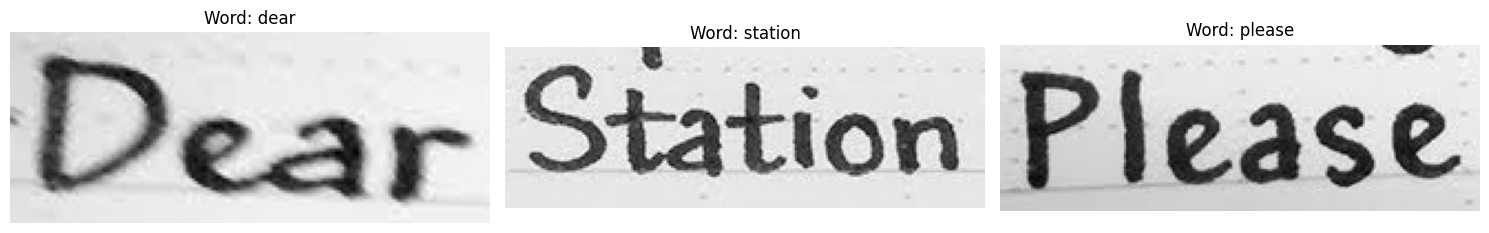

In [ ]:
import matplotlib.pyplot as plt

# Select a few sample fragments from page1_fragments_data
sample_fragments = page1_fragments_data['fragments'][::20] # Select every 20th fragment

plt.figure(figsize=(15, 5))

for i, fragment in enumerate(sample_fragments):
    fragment_path = fragment['fragment_path']
    recognized_text = fragment['text']

    # Load the image
    img = cv2.imread(fragment_path, cv2.IMREAD_GRAYSCALE)

    if img is not None:
        plt.subplot(1, len(sample_fragments), i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'Word: {recognized_text}')
        plt.axis('off')
    else:
        print(f"Could not load image: {fragment_path}")

plt.tight_layout()
plt.show()

In [ ]:
# Instantiate the OCRMapper (only needed for finding common candidates now)
ocr_mapper = OCRMapper()

# Find common words between the two sets of fragments
common_words = ocr_mapper.find_common_candidates(page1_fragments_data['fragments'], page2_fragments_data['fragments'])

# Print the set of common words found
print("Common words found:")
print(common_words)

Found 11 biometrically-rich candidates.
Common words found:
{'weekends', 'please', 'nine', 'from', 'the', 'king', 'school', 'eleven', 'village', 'three', 'certain'}


Displaying fragments for word: 'weekends'


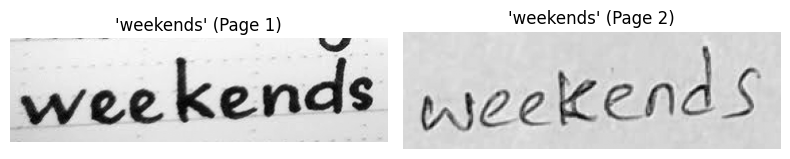

Displaying fragments for word: 'please'


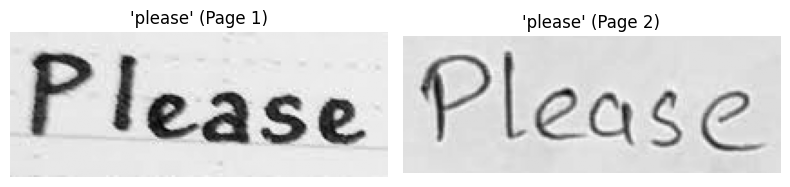

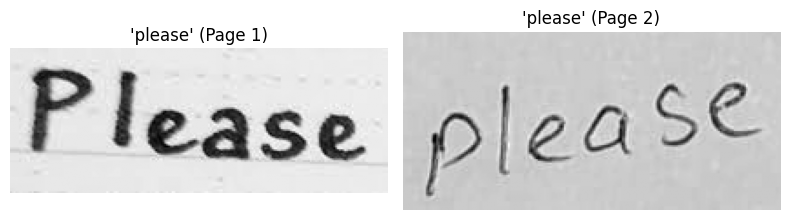

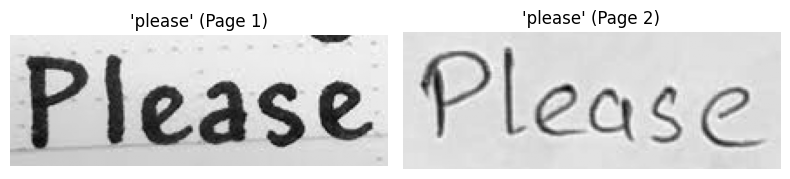

Displaying fragments for word: 'nine'


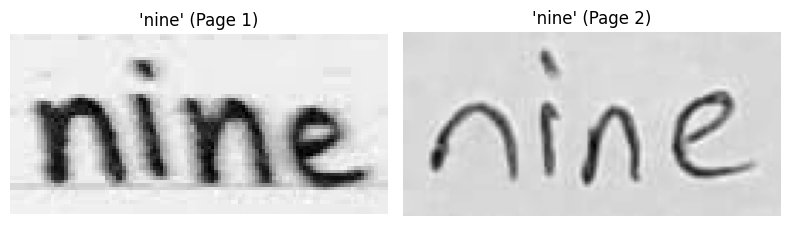

Displaying fragments for word: 'from'


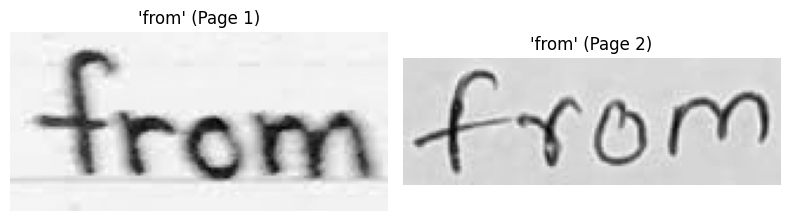

Displaying fragments for word: 'the'


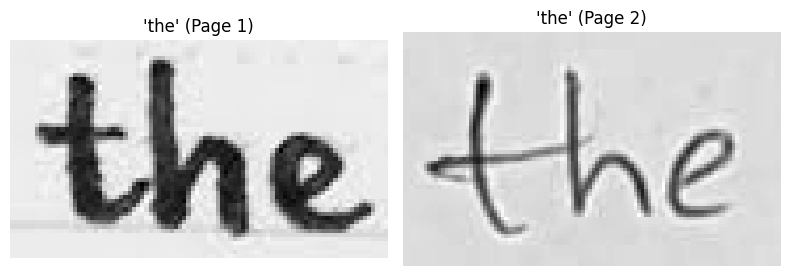

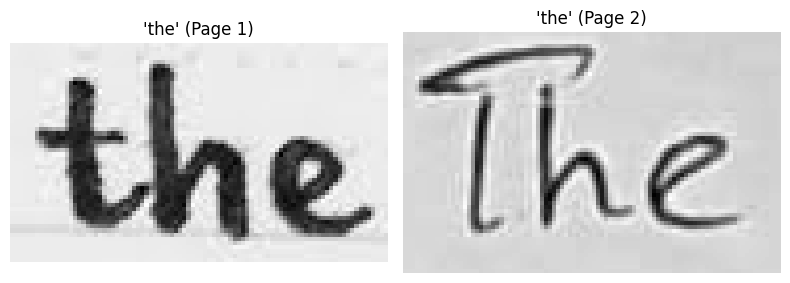

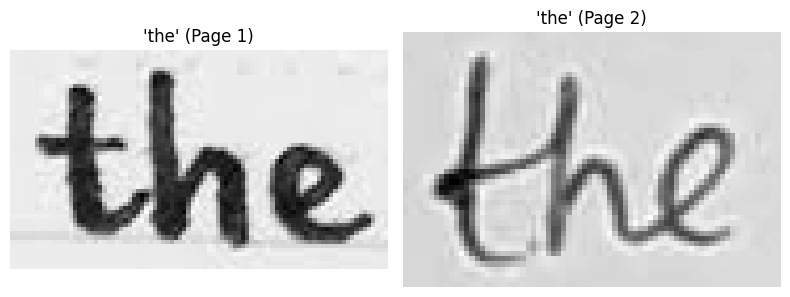

In [ ]:
import matplotlib.pyplot as plt

# Select a few common words to display (e.g., first 5)
words_to_display = list(common_words)[:5]

for word in words_to_display:
    # Get fragments for the current word from both pages
    fragments1 = [f for f in page1_fragments_data['fragments'] if f.get('text') == word]
    fragments2 = [f for f in page2_fragments_data['fragments'] if f.get('text') == word]

    if not fragments1 or not fragments2:
        print(f"Skipping word '{word}': Fragments not found in both pages.")
        continue

    print(f"Displaying fragments for word: '{word}'")

    # Limit the number of pairs displayed per word for brevity
    max_pairs_per_word = 3
    num_pairs_displayed = 0

    for frag1 in fragments1:
        for frag2 in fragments2:
            if num_pairs_displayed >= max_pairs_per_word:
                break

            img1_path = frag1.get('fragment_path')
            img2_path = frag2.get('fragment_path')

            if not img1_path or not img2_path:
                continue

            img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
            img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

            if img1 is not None and img2 is not None:
                plt.figure(figsize=(8, 4))

                plt.subplot(1, 2, 1)
                plt.imshow(img1, cmap='gray')
                plt.title(f"'{word}' (Page 1)")
                plt.axis('off')

                plt.subplot(1, 2, 2)
                plt.imshow(img2, cmap='gray')
                plt.title(f"'{word}' (Page 2)")
                plt.axis('off')

                plt.tight_layout()
                plt.show()

                num_pairs_displayed += 1
        if num_pairs_displayed >= max_pairs_per_word:
            break



Processing word for feature extraction: 'weekends'


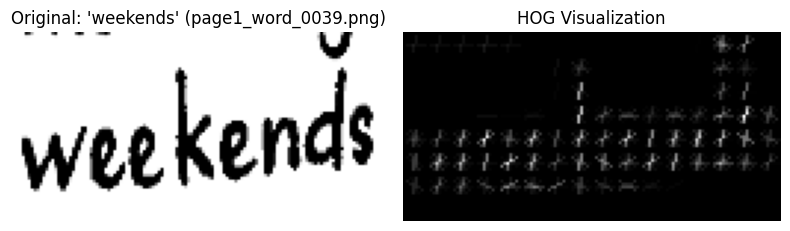

  Fragment: page1_word_0039.png
    Structural Features (f_struct): [0. 0. 0. 0.]
    Geometric Features (f_geom): [  2. -90.  21.   0.]
    Statistical Features (f_stat): [0.5 0.  0.  0.  0.5 0.  0.  0.  0.  0.5]...
    Transform Features (f_trans): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...


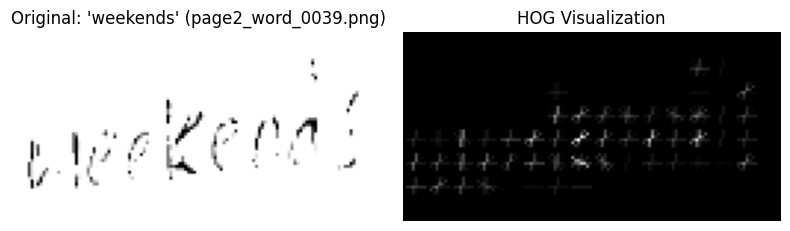

  Fragment: page2_word_0039.png
    Structural Features (f_struct): [0. 0. 0. 0.]
    Geometric Features (f_geom): [  2. -90.  31.   0.]
    Statistical Features (f_stat): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...
    Transform Features (f_trans): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...

Processing word for feature extraction: 'please'


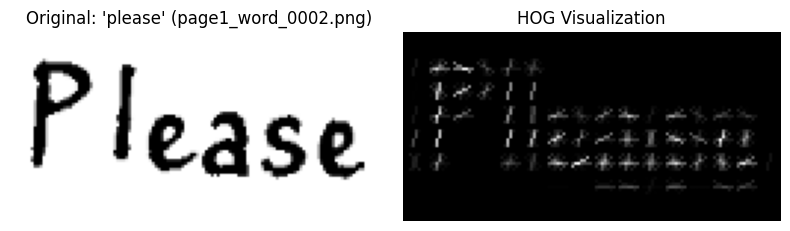

  Fragment: page1_word_0002.png
    Structural Features (f_struct): [0. 0. 0. 0.]
    Geometric Features (f_geom): [  2. -90.  31.   0.]
    Statistical Features (f_stat): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...
    Transform Features (f_trans): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...


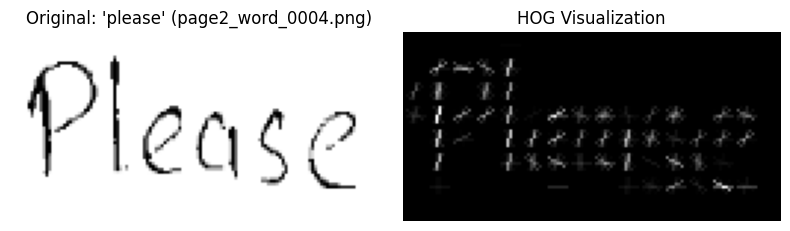

  Fragment: page2_word_0004.png
    Structural Features (f_struct): [0. 0. 0. 0.]
    Geometric Features (f_geom): [  2. -90.  31.   0.]
    Statistical Features (f_stat): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...
    Transform Features (f_trans): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]...


In [ ]:
import matplotlib.pyplot as plt
from skimage.feature import hog
import cv2
import numpy as np
import os

# Select a few common words to visualize features for
words_to_visualize = list(common_words)[:2] # Select the first 3 common words

# Instantiate the feature extractor
feature_extractor = HandcraftedFeatureExtractor()

for word in words_to_visualize:
    print(f"\nProcessing word for feature extraction: '{word}'")

    # Get fragments for the current word from both pages
    fragments1 = [f for f in page1_fragments_data['fragments'] if f.get('text') == word]
    fragments2 = [f for f in page2_fragments_data['fragments'] if f.get('text') == word]

    if not fragments1 or not fragments2:
        print(f"No fragments found for word '{word}' in both pages. Skipping.")
        continue

    # Process one fragment from each page
    fragments_to_process = []
    if fragments1:
        fragments_to_process.append(fragments1[0])
    if fragments2:
        fragments_to_process.append(fragments2[0])


    for i, fragment in enumerate(fragments_to_process):
        fragment_path = fragment.get('fragment_path')
        if not fragment_path or not os.path.exists(fragment_path):
            print(f"Fragment image not found at {fragment_path}. Skipping.")
            continue

        try:
            img = cv2.imread(fragment_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                print(f"Could not read image from {fragment_path}. Skipping.")
                continue

            # Resize the image to the fixed size for consistent feature extraction
            resized_img = feature_extractor._resize(img)

            # Extract HOG features with visualization
            hog_features, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                                          cells_per_block=(2, 2), visualize=True)

            # Display the original image and the HOG visualization
            plt.figure(figsize=(8, 4))

            plt.subplot(1, 2, 1)
            plt.imshow(resized_img, cmap='gray')
            plt.title(f"Original: '{word}' ({os.path.basename(fragment_path)})")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(hog_image, cmap='gray') # HOG image is typically grayscale
            plt.title("HOG Visualization")
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            # Print a few feature values as before
            f_struct = feature_extractor._get_structural_features(resized_img)
            f_geom = feature_extractor._get_geometric_features(resized_img)
            f_stat = feature_extractor._get_statistical_features(resized_img)
            f_trans = feature_extractor._get_transform_features(resized_img)


            print(f"  Fragment: {os.path.basename(fragment_path)}")
            print(f"    Structural Features (f_struct): {f_struct}")
            print(f"    Geometric Features (f_geom): {f_geom}")
            # Print only first few elements of f_stat and f_trans as they are large
            print(f"    Statistical Features (f_stat): {f_stat[:10]}...")
            print(f"    Transform Features (f_trans): {f_trans[:10]}...")


        except Exception as e:
            print(f"Error processing fragment {fragment_path}: {e}")
            continue

In [ ]:
# Instantiate the OCRMapper (only needed for finding common candidates now)
ocr_mapper = OCRMapper()

# Find common words between the two sets of fragments
common_words = ocr_mapper.find_common_candidates(page1_fragments_data['fragments'], page2_fragments_data['fragments'])

# Print the set of common words found
print("Common words found:")
print(common_words)

Found 11 biometrically-rich candidates.
Common words found:
{'weekends', 'please', 'nine', 'from', 'the', 'king', 'school', 'eleven', 'village', 'three', 'certain'}


In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean

# Use the HandcraftedVerifier to verify writers and get the verification result

print("\nHandcrafted Verification Result:")
handcrafted_verifier_euclidean = HandcraftedVerifier()
handcrafted_verification_result_euclidean = handcrafted_verifier_euclidean.verify_writers(
    page1_fragments_data['fragments'],
    page2_fragments_data['fragments'],
    common_words
)

print("\nHandcrafted Verification Result (with Consistency Weighting and Euclidean Distance):")
print(handcrafted_verification_result_euclidean)
# Instantiate the SiameseVerifier
siamese_verifier = SiameseVerifier() # Use default mock model

# Use the SiameseVerifier to verify writers and get the verification result
siamese_verification_result = siamese_verifier.verify_writers(page1_fragments_data['fragments'],
                                                              page2_fragments_data['fragments'],
                                                              common_words)

print("\nSiamese Verification Result:")
print(siamese_verification_result)


Handcrafted Verification Result:
Computing feature vectors and consistency for common words...
Computing feature vectors and consistency for common words...

Handcrafted Verification Result (with Consistency Weighting and Euclidean Distance):
{'decision': 'Different Writers', 'score': 123.25077953620548, 'common_words_compared': 11, 'total_comparisons': 25}
No model path provided. Using mock model.
Creating mock model...
Mock model created.
Comparing with Deep Learning (Siamese) pipeline...

Siamese Verification Result:
{'decision': 'Different Writers', 'score': -0.034540351446684416, 'common_words_compared': 11, 'total_comparisons': 25}
